<a href="https://colab.research.google.com/github/fedhere/DSPS/blob/master/KS_earthquakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by FedericaBBianco @fedhere September 2019 for UDel PHYS467/667
# Kolmogorov Smirnoff test, application to earthquake data

In [809]:
#all the imports I needed
from __future__ import print_function, division
import numpy as np
import pandas as pd
import pylab as pl
import scipy as sp
import seaborn as sn
from scipy import stats
%pylab inline
pl.style.use("https://raw.githubusercontent.com/fedhere/DSPS/master/fbb.mplstyle")

Populating the interactive namespace from numpy and matplotlib


This homework asks you to reproduce the work in [Corral 2018](https://arxiv.org/pdf/0910.0055.pdf) which is well described, but not "reproducible". 
Corral 2018 uses a K-S test to show that at different magnitude scales the time gaps between earthquakes follows the same distribution. If true, this indicates that there is a consistent scaling law. 

The argument is a little convoluted, but it is a somewhat innovative use of the test. Corall compares the time gap between earthquakes  greater than a certain magnitude threshold with the time gaps between earthquakes above a different threshold, and finds no differences.

Remind yourself exactly what the K-S test is about :

    1 What is the test's Null Hypothesis that the K-S test tests?
    
    


> The Null Hypothesis is that two data sets are from the same distribution.



    2 What is the "statistic" or "pivotal quantity" that the test uses?
    


> The pivotal quantity is the maximum difference between the rescaled cumulative distributions of the two data sets. 



    3 What does the probability distribution of this statistic depend on? 

> The probability of this statistic depend on the number of data points $n$ and distance of cumulative distribution $d$.



# Data Retrival

The first reason why the paper is not techincally _reproducible_ is that, while a link is provided to retrieve the data, the link is dead. This happens often. Services like [Zenodo](https://zenodo.org/) or journals that serve data provide some insurance against this but unfortunately the standards are not strict. 

If you are taking this class as 667 retrieve the data yourself from [this website](http://service.scedc.caltech.edu/eq-catalogs/poly.php). Make sure the number of entries in your final dataset is similar to that of the authors. I got 70798, instead of 77000. 10% off, which I deem close enough. You should get something similar. Use the map in the paper to determine the region of interest. Call the file earthquakes_\<firstinitialLastname\>.csv and upload it to your github repository. Read it your file, instead of mine as instructed below. If you are getting weird results compare to what I got, go back and check how the files differ.

# Data Ingestion

## read in data

I saved the data in a file called "earthquakes.csv", where ```csv``` stands for "comma separated file". [This file format](https://www.howtogeek.com/348960/what-is-a-csv-file-and-how-do-i-open-it/) requires different entries in a row to be separated by commas alone (no space) and for commas to be used in quote if they are not intended to separate entries. 

```
a,b,c
d,e,f
g,"h,2",i
```
The data is uploaded on the  github homework repository but to read it in you will need to get the link to the *raw file*: the link to the file https://github.com/fedhere/DSPS/blob/master/HW3/earthquakes.csv  takes you to an ```html``` page that includes the content of the file, but you want to isolate the content of the file itself: the _raw file_. Pay attention to this: from the next time I will not give you the exact link, I will just point you to the file and you will have to find the link to the raw data from there. 
https://raw.githubusercontent.com/fedhere/DSPS/master/HW3/earthquakes.csv

The data can be read effectively using the _pandas_ python package as ```pandas.read_csv(<file name or URL>)```. 

However, I did not format the data correctly, according to the csv extension requirement. This happens all the time. Look at the file and use the pandas documentation to figure out how to read it with ```pd.read_csv()```

In [808]:
#your code here...
# all earthquake events  
eqall = pd.read_csv("eqall.csv", delim_whitespace=True, comment="#")
eqall.head()

,YYY/MM/DD,HH:mm:SS.ss,ET,GT,MAG,M,LAT,LON,DEPTH,Q,EVID,NPH,NGRM
0,1984/01/01,00:25:08.58,eq,l,1.88,c,34.053,-117.247,13.3,C,28253,14,26
1,1984/01/01,01:30:57.52,eq,l,2.02,c,33.246,-116.433,1.6,C,28255,13,17
2,1984/01/01,04:44:18.55,eq,l,1.87,c,34.068,-117.323,16.3,C,28258,17,21
3,1984/01/01,05:31:34.16,eq,l,2.12,c,32.945,-116.295,5.4,C,28259,18,42
4,1984/01/01,06:59:05.14,eq,l,2.43,c,33.343,-117.628,5.6,C,28260,13,30


In [815]:
# select where MAG>=2 save as eqdata
eqdata = eqall[eqall.MAG >= 2]

running the following lines of code should give you the same result as mine if you used the file I provided (467 students), and qualitatively  similar if you are using your own data (667 students)

In [816]:
eqdata.shape

(70798, 13)

In [817]:
eqdata.head()

,YYY/MM/DD,HH:mm:SS.ss,ET,GT,MAG,M,LAT,LON,DEPTH,Q,EVID,NPH,NGRM
1,1984/01/01,01:30:57.52,eq,l,2.02,c,33.246,-116.433,1.6,C,28255,13,17
3,1984/01/01,05:31:34.16,eq,l,2.12,c,32.945,-116.295,5.4,C,28259,18,42
4,1984/01/01,06:59:05.14,eq,l,2.43,c,33.343,-117.628,5.6,C,28260,13,30
8,1984/01/01,11:10:25.29,eq,l,2.07,c,33.668,-116.780,13.8,C,28270,19,40
16,1984/01/01,19:38:19.79,eq,l,2.13,c,33.963,-116.290,2.7,C,28553,40,49


In [818]:
eqdata.describe()

,MAG,LAT,LON,DEPTH,EVID,NPH,NGRM
count,70798.000000,70798.000000,70798.00000,70798.000000,7.079800e+04,70798.000000,70798.000000
mean,2.417826,33.977749,-116.88145,5.707677,3.699163e+06,30.424376,175.725049
std,0.407683,1.156586,1.07667,3.842620,3.495378e+06,22.374143,226.196774
min,2.000000,30.094830,-121.76000,0.000000,2.825500e+04,0.000000,0.000000
25%,2.120000,33.061000,-117.69200,3.100000,7.380962e+05,15.000000,59.000000
50%,2.300000,34.056750,-116.59000,5.300000,3.049477e+06,24.000000,111.000000
75%,2.590000,34.591000,-116.25100,6.900000,3.325926e+06,39.000000,211.000000
max,7.100000,37.985500,-113.71900,29.300000,3.736673e+07,406.000000,3815.000000


now that you have a dataframe object you can use methods of the object to modify it. Use the method ```eqdata.rename``` to change the names of the 3 columns that are the only three relevant to us: _date, time, magnitude_

## prepare date-time column

In [819]:
# your code here...
eqdata_prep = pd.DataFrame()
eqdata_prep[['date', 'time', 'mag']] = eqdata[['YYY/MM/DD', 'HH:mm:SS.ss', 'MAG']]
eqdata_prep = eqdata_prep.reset_index(drop=True)

In [820]:
eqdata_prep.head()

,date,time,mag
0,1984/01/01,01:30:57.52,2.02
1,1984/01/01,05:31:34.16,2.12
2,1984/01/01,06:59:05.14,2.43
3,1984/01/01,11:10:25.29,2.07
4,1984/01/01,19:38:19.79,2.13


In [821]:
eqdata_prep.describe()

,mag
count,70798.000000
mean,2.417826
std,0.407683
min,2.000000
25%,2.120000
50%,2.300000
75%,2.590000
max,7.100000


Now you want to combine the columns containing date and time and convert them to a "datetime" kind of data object. 


What data type are the _time_ and _date_ columns right now? What tyoe you want them to be to conver them to datetime with ```pd.datetime()```?

In [822]:
eqdata_prep.time.dtype, eqdata_prep.date.dtype

(dtype('O'), dtype('O'))

to do this conversion I 

   1 joined date and time into a single string for each row with a ["list comprehension"](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python) (essentially a for loop but more efficient and compact). You do not have to do it with a list comprehension, you can use just a for loop.

   2 used pd.datetime() to convert the resulting new dataframe column into a dataframe column containing _datetime_ objects (see lab)

   3 but this did not work because of the formatting of some dates, so I had to go back and fix 5 entries. (you are on your own to figure out this one)

In [823]:
# your code here
# combine data and time
eqdata_prep['datetime'] = eqdata_prep['date'] +' ' + eqdata_prep['time']

In [824]:
eqdata_prep.head()

,date,time,mag,datetime
0,1984/01/01,01:30:57.52,2.02,1984/01/01 01:30:57.52
1,1984/01/01,05:31:34.16,2.12,1984/01/01 05:31:34.16
2,1984/01/01,06:59:05.14,2.43,1984/01/01 06:59:05.14
3,1984/01/01,11:10:25.29,2.07,1984/01/01 11:10:25.29
4,1984/01/01,19:38:19.79,2.13,1984/01/01 19:38:19.79


In [826]:
# several datetime are in wrong formats we can just drop them later
eqdata_prep['datetime'][1723] # one example of time in wrong format

'1984/08/09 04:48:60.00'

In [828]:
# convert to pandas datatime object, use 'coerce' to return NaT for wrong time format
eqdata_prep['datetime'] = pd.to_datetime(eqdata_prep['datetime'], errors='coerce')
eqdata_prep = eqdata_prep.dropna() 

In [829]:
eqdata_prep.shape

(70793, 4)

In [830]:
eqdata_prep.head()

,date,time,mag,datetime
0,1984/01/01,01:30:57.52,2.02,1984-01-01 01:30:57.520
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790


## select valuable data

Following the description in Section 2  of Corral 2018 I removed all data that did not belong to a "stationary" period. Third paragraph section 2 of Corral 2018. You can see the cell of code I used to do this [here](https://github.com/fedhere/DSPS/blob/master/HW3/Corral2018_selectStationary.py) at no points cost, cause it was a bit tricky, but I encourage you to try and do it yourself. If you can do it in fewer lines than I did its automatically +5 points (just turning the loop into a list comprehension does not count. That is an obvious way to decrease the number of lines of code; I did not do it simply to enhance readability.)

In [831]:
# use this comand to convert the time of stationary periods in paper to DateTimeIndex
pd.to_datetime(arg=[0.5*365], unit='d', origin='2002-01-01')


DatetimeIndex(['2002-07-02 12:00:00'], dtype='datetime64[ns]', freq=None)

In [832]:
# all stationary periods 
st_begin = ['1984-01-01', '1990-04-20', '1994-08-08', '1996-02-06', 
            '1997-01-01', '1997-10-01', '1998-04-02', '2000-07-19', 
            '2000-11-24', '2001-08-08', '2002-07-02']
st_end = ['1986-07-02', '1992-02-06', '1995-08-08', '1996-07-01', 
          '1997-08-08', '1998-02-24', '1999-05-08', '2000-10-19', 
          '2001-04-02', '2002-01-1', '2002-12-31']


In [833]:
# select data within stationary periods and calculate the gaps 
df = eqdata_prep
df = df.set_index(df['datetime'])
df_good = []
for i_,stb in enumerate(st_begin):
    # select the events during stationary period
    df_st = df.loc[st_begin[i_]:st_end[i_]]
    print('stationary period',i_, st_begin[i_],st_end[i_], 'enents', len(df_st.index))

    # calculate gaps and drop the first item
    gaps = np.diff(df_st['datetime'].astype(int)) # show in int format 
    #gaps = np.diff(df_st['datetime'])   # show in time format
    df_st_withgaps = df_st.drop(df_st.index[0]) # drop the first term
    df_st_withgaps['gaps'] = gaps
    df_good.append(df_st_withgaps)

# stack all events within periods
eqGoodData = pd.concat(df_good)

stationary period 0 1984-01-01 1986-07-02 enents 6171
stationary period 1 1990-04-20 1992-02-06 enents 3131
stationary period 2 1994-08-08 1995-08-08 enents 1785
stationary period 3 1996-02-06 1996-07-01 enents 699
stationary period 4 1997-01-01 1997-08-08 enents 1365
stationary period 5 1997-10-01 1998-02-24 enents 813
stationary period 6 1998-04-02 1999-05-08 enents 2321
stationary period 7 2000-07-19 2000-10-19 enents 420
stationary period 8 2000-11-24 2001-04-02 enents 749
stationary period 9 2001-08-08 2002-01-1 enents 799
stationary period 10 2002-07-02 2002-12-31 enents 658


In [479]:
print ("there are {} earthquakes falling in the selected stationary periods".
       format(len(eqGoodData['datetime'])))


there are 18900 earthquakes falling in the selected stationary periods


In [834]:
eqGoodData.shape

(18900, 5)

In [835]:
eqGoodData.head()

,date,time,mag,datetime,gaps
datetime,,,,,
1984-01-01 05:31:34.160,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,14436640000000
1984-01-01 06:59:05.140,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,5250980000000
1984-01-01 11:10:25.290,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,15080150000000
1984-01-01 19:38:19.790,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,30474500000000
1984-01-01 19:39:19.670,1984/01/01,19:39:19.67,2.13,1984-01-01 19:39:19.670,59880000000


In [836]:
eqGoodData.describe()

,mag,gaps
count,18900.000000,1.890000e+04
mean,2.399380,1.554400e+13
std,0.392395,1.882664e+13
min,2.000000,1.700000e+08
25%,2.110000,2.733615e+12
50%,2.290000,8.930935e+12
75%,2.562500,2.129492e+13
max,5.800000,2.365828e+14


Note that the first entry will be NaT which is Not a Time (corresponding to nan for numerical variables) or maybe a negative number (depends on your exact operations above). You should remove it

In [0]:
# your code here
# already drop the first term in above 

In [837]:
# final prepared data
eqGoodData.head()

,date,time,mag,datetime,gaps
datetime,,,,,
1984-01-01 05:31:34.160,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,14436640000000
1984-01-01 06:59:05.140,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,5250980000000
1984-01-01 11:10:25.290,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,15080150000000
1984-01-01 19:38:19.790,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,30474500000000
1984-01-01 19:39:19.670,1984/01/01,19:39:19.67,2.13,1984-01-01 19:39:19.670,59880000000


# data exploration
At this point you should wonder if this is the final dataset that you want to use and if anything is weird or suspicious about it. Visualize the distribution. A good way to visualize distributions is a histogram which you can prodice with pl.hist() or as a method of your dataframe series as ```df[SeriesName].plot(kind="hist")```. Produce a plot like the one below (label the axis! and describe it with a caption!). To get the logarithmic y axis you can se ```logy=True```, for example. in your ```df[SeriesName].plot``` call.

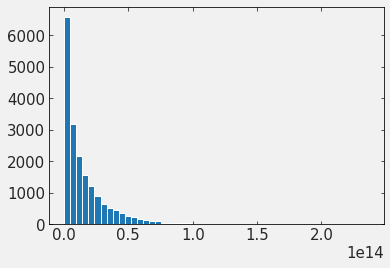

In [845]:
h_ = pl.hist(eqGoodData['gaps'], bins=50, density=False)

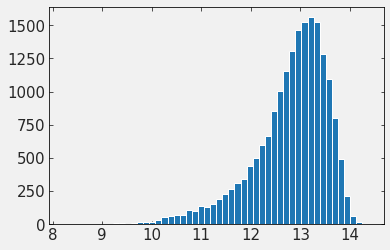

In [841]:
# in log 
h_ = pl.hist(np.log10(eqGoodData['gaps']), bins=50, density=False)


The thing that worries me is that by removing some sections of the data to use only stationary periods we created some artificially large gaps: gaps of order ~month. How many nanoseconds in a month? remove all gaps that are larger than about a month and see how the distribution looks (make another histogram).

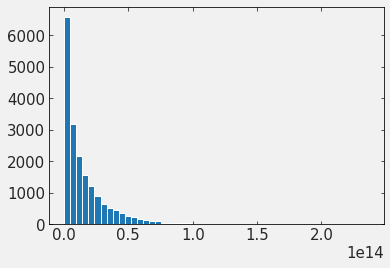

In [849]:
# your code here 
# remove gaps larger than a month  or 2.63*10^15 ns
data = eqGoodData[(eqGoodData.gaps <= 2.63*10**15)]

h_ = pl.hist(data['gaps'], bins=50, density=False, cumulative=False)

# data analysis

### important: the paper does not do it but I want you to formally choose a threshold before you do this test. Choose a p-value (=$\alpha$ thresold: call your variable ```alpha```) of 3-$\sigma$.

In [753]:
# set a threshold before test
alpha = 0.05

Follow the instructions (algorithm) in **Section 3 paragraph 3** and compare your results with the results in table 1 with a threshold  of = 0.01 and 0.001

Do it for all 5 magnitude thresholds as indicated in the paper (and in Table 1).

Note that the x axis in plot Fig 1 is in _log space_. Use ```np.log10()``` to take the logarithm of the time gaps.

The pseudocode for the algorithm is [here](https://github.com/fedhere/DSPS/blob/master/HW3/Corral2018_pseudocode.md).


Reproduce the paper Fig 1 and Table 1. In the Table report the size of each dataset after cleaning the value of the statistic and the p-value, as done in Corral 2018. Use the scipy function for the 2 sample KS test. (resources [here](https://colab.research.google.com/notebooks/markdown_guide.ipynb#scrollTo=70pYkR9LiOV0) to learn about the table syntax in markdown)

In [850]:
def get_sample(m=0.01, M = [2.0, 2.5, 3.0, 3.5, 4.0]):
    # get the scaled gaps from prepred data
    sample_scaled = []
    for Mi in M:
        temp = eqGoodData[eqGoodData.mag >= Mi]
        t_mean = np.mean(temp.gaps)
        # remove small gaps
        temp = temp[temp['gaps'] >= m*t_mean]
        # scale by the new mean
        t_mean = np.mean(temp.gaps)
        gaps_scaled = temp['gaps'].values/t_mean
        sample_scaled.append(gaps_scaled)
    
    return sample_scaled

In [851]:
def ks_test(m = 0.01, M = [2.0, 2.5, 3.0, 3.5, 4.0]):
    # perform ks test
    sample_scaled = get_sample(m, M)
    pvalue = np.ones((len(M), len(M)))
    dvalue = np.zeros((len(M), len(M)))
    
    for i in range(len(M)):
        for j in range(i,len(M)):
            # perform ks test 
            d, p = stats.ks_2samp(sample_scaled[i], sample_scaled[j])
            pvalue[i, j] =  p
            pvalue[j, i] =  p
            dvalue[i, j] =  d
            dvalue[j, i] =  d
    return sample_scaled, dvalue, pvalue

In [852]:
def plot_hist(sample):
    pl.figure(figsize=(8, 6))
    for i in range(len(sample)):
        hist = pl.hist(np.log10(sample[i]), bins=1000, cumulative=True, 
                       histtype='step', density=True, label=('M$\geq$%0.1f'%M[i])) 
    pl.legend(loc='upper left')
    pl.xlabel('x = $Log_{10}(R_s\\tau$)')
    pl.ylabel('$P(x)$')

### Analysis for m = 0.01

In [853]:
m = 0.01
M = [2.0, 2.5, 3.0, 3.5, 4.0]
# do ks-test
sample, dvalue, pvalue = ks_test(m, M)

In [854]:
# check mean of sample
[np.mean(si) for si in sample]

[1.0, 1.0, 1.0, 1.0, 0.9999999999999999]

In [855]:
# check len  of each sample
[len(si) for si in sample]

[18025, 5409, 1357, 392, 111]

In [654]:
dvalue

array([[0.        , 0.01474507, 0.02706803, 0.06348029, 0.11671177],
       [0.01474507, 0.        , 0.02249792, 0.05464862, 0.11431898],
       [0.02706803, 0.02249792, 0.        , 0.05337968, 0.1153578 ],
       [0.06348029, 0.05464862, 0.05337968, 0.        , 0.07570325],
       [0.11671177, 0.11431898, 0.1153578 , 0.07570325, 0.        ]])

In [653]:
pvalue

array([[1.        , 0.32396221, 0.30952564, 0.08726556, 0.09185192],
       [0.32396221, 1.        , 0.6376357 , 0.21867779, 0.10843875],
       [0.30952564, 0.6376357 , 1.        , 0.34286591, 0.1213643 ],
       [0.08726556, 0.21867779, 0.34286591, 1.        , 0.68768492],
       [0.09185192, 0.10843875, 0.1213643 , 0.68768492, 1.        ]])

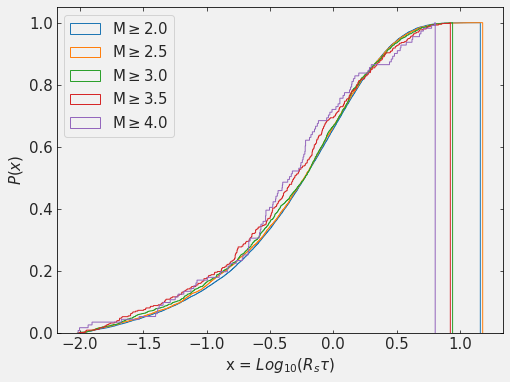

In [856]:
plot_hist(sample)

#### Figure. 

Did you find any statistical significant differences between the distributions? What does it mean? Is your result identical to Correll's 2018? Why or why not? **Discuss!**

summary table

> sample size is small for large M

### 667 students ( or extra credits)

Organize your result for different magnitude threshold in a numpy array (it should be a 5x5 array) for both cutoffs (0.01 and 0.001). Each of these arrays should contain the p-value for the pair of distributions i,j in cell \[i\]\[j\] and \[j\]\[i\]. Use ```imshow``` to visualize this 2D data. FIrst visualize the matrix itself as done below.

In [857]:
# your code here
def plot_pvalue(pvalue):    
    pl.imshow((pvalue));
    pl.axis('off')
    cb = pl.colorbar()
    cb.ax.set_ylabel(r'$p$-value')
    pl.title("KS test results");
    #add a caption
def plot_heatmap(pvalue):
    ticklabels = ['M$\geq$%.1f'%M[i] for i in range(5)]
    sn.heatmap(pvalue, annot=True, vmin=0, vmax=1, linewidths=.2,
               xticklabels=ticklabels, yticklabels=ticklabels)
    pl.title('KS test results')

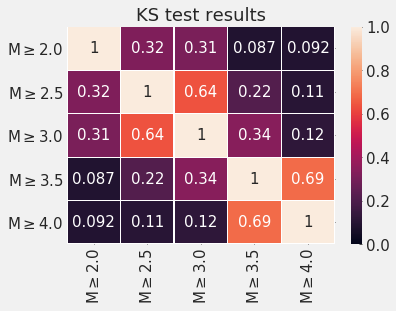

In [858]:
plot_heatmap(pvalue)

#### Figure. 


Now visualize the result as a matrix where the cells are white if the results is not statistically significant and red otherwise. 
After doing it fot the set alpha threshold, lower your alpha threshold so that at least one pair of distribution has a statistically significant difference. **Warning!! this is an unethocal horrifying practice! Once you chose your significance threshold you are never allowed to change it! Why? Discuss**

In [860]:
pvalue_check = pvalue > alpha
pvalue_check

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

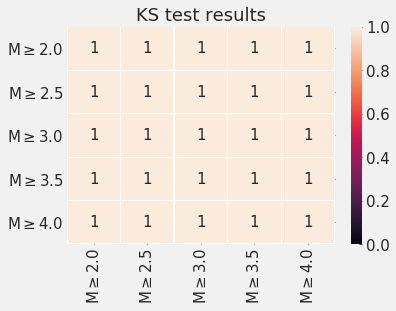

In [804]:
plot_heatmap(pvalue_check)

### Redoing it for threshold m = 0001

In [764]:
m = 0.001
M = [2.0, 2.5, 3.0, 3.5, 4.0]
sample, dvalue, pvalue = ks_test(m, M)

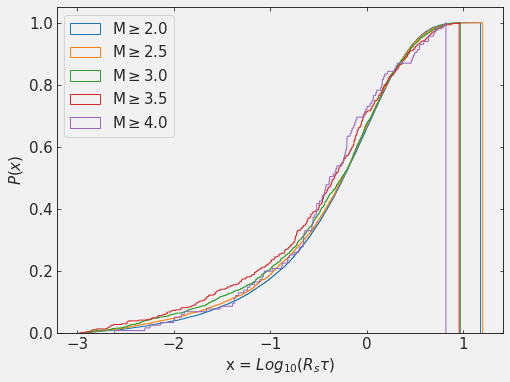

In [765]:
plot_hist(sample)

#### Figure.

summary table 

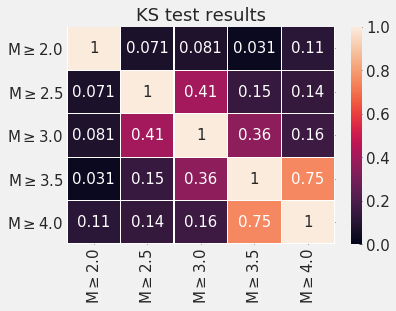

In [801]:
plot_heatmap(pvalue)

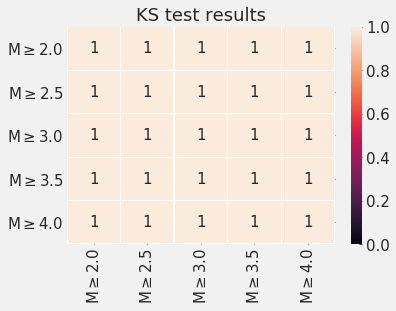

In [800]:
pvalue_check = pvalue > alpha
plot_heatmap(pvalue_check)

## Conclusion

In this project, We reproduce the work. 

sample may slightly different, 

We can not reject the null hypothesis there is scaling law. 